In [19]:
!pip -q install pandas numpy statsmodels scipy matplotlib openpyxl

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_breusch_godfrey, het_white
from statsmodels.stats.stattools import durbin_watson

In [3]:
# We import the processed dataset

url = "https://github.com/MillerGuevara/EU_CARS_2016_2024/raw/refs/heads/main/Databases/processed/EU_CARS_DATABASE.xlsx"
df = pd.read_excel(url, sheet_name='Quarterly')

df["QUARTER_END_DATE"] = pd.to_datetime(df["QUARTER_END_DATE"])
df = df.sort_values("QUARTER_END_DATE").set_index("QUARTER_END_DATE")
df.head(5)

,YEAR,QUARTER_NUM,QUARTER_YEAR,PASSENGER_CAR_REGISTRATIONS,MOTOR_VEHICLE_PROD_INDEX_2021,HICP_MOTOR_CARS,INTEREST_RATE_HOUSEHOLD_CONSUMPTION,GDP,POST_CO2_STANDARDS_2019,TRAVEL_BAN_COVID
QUARTER_END_DATE,,,,,,,,,,
2016-03-31,2016,1,2016Q1,2706186,134.833333,100.396667,5.993333,2541092.7,0,0
2016-06-30,2016,2,2016Q2,2975769,135.966667,100.253333,5.876667,2545975.1,0,0
2016-09-30,2016,3,2016Q3,2319907,124.000000,100.236667,5.820000,2558295.2,0,0
2016-12-31,2016,4,2016Q4,2457906,127.400000,100.256667,5.536667,2577850.2,0,0
2017-03-31,2017,1,2017Q1,2924412,134.433333,100.803333,5.656667,2598643.9,0,0


In [4]:
# We identify numeric columns, if they exist

num_cols = [
    "PASSENGER_CAR_REGISTRATIONS",
    "MOTOR_VEHICLE_PROD_INDEX_2021",
    "HICP_MOTOR_CARS",
    "INTEREST_RATE_HOUSEHOLD_CONSUMPTION",
    "GDP"
]

for c in num_cols:
    df[c] = (df[c].astype(str)
                  .str.replace(",", "", regex=False)
                  .str.replace(" ", "", regex=False)
                  .replace("", np.nan))
    df[c] = pd.to_numeric(df[c], errors="coerce")

dummy_cols = ["POST_CO2_STANDARDS_2019", "TRAVEL_BAN_COVID"]
for c in dummy_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce").astype(int)

df.isna().sum()

,0
YEAR,0
QUARTER_NUM,0
QUARTER_YEAR,0
PASSENGER_CAR_REGISTRATIONS,0
MOTOR_VEHICLE_PROD_INDEX_2021,0
HICP_MOTOR_CARS,0
INTEREST_RATE_HOUSEHOLD_CONSUMPTION,0
GDP,0
POST_CO2_STANDARDS_2019,0
TRAVEL_BAN_COVID,0


In [5]:
# We log level variables (elasticities)

df["ln_reg"]   = np.log(df["PASSENGER_CAR_REGISTRATIONS"])
df["ln_prod"]  = np.log(df["MOTOR_VEHICLE_PROD_INDEX_2021"])
df["ln_price"] = np.log(df["HICP_MOTOR_CARS"])
df["ln_gdp"]   = np.log(df["GDP"])

df["rate"]     = df["INTEREST_RATE_HOUSEHOLD_CONSUMPTION"]
df["post2019"] = df["POST_CO2_STANDARDS_2019"]
df["covid"]    = df["TRAVEL_BAN_COVID"]

## Data and variables (EA20 / EU aggregate, quarterly)

**Sample:** 2016Q1–2024Q4 (36 quarterly observations).

**Construction choices (what I did and why):**
- I used **quarterly frequency** because GDP is quarterly and the goal is a time-series equilibrium analysis.
- **Registrations** are treated as a **quarterly total** (sum of monthly registrations). This matches the magnitude of the series (around 2–3 million per quarter).
- **Index variables** (production index, HICP motor cars) are treated as **quarterly averages** of monthly index values.
- I log-transform level variables to interpret coefficients more easily and reduce scale effects:
  - `ln_reg = log(PASSENGER_CAR_REGISTRATIONS)`
  - `ln_prod = log(MOTOR_VEHICLE_PROD_INDEX_2021)`
  - `ln_price = log(HICP_MOTOR_CARS)`
  - `ln_gdp = log(GDP)`
- The **interest rate** is kept in levels (`rate`) because it is already a percentage and logging rates is not standard.

**Key dummy variables (fixed by dataset design):**
- `post2019` = 1 starting **2020Q1** in this dataset (policy regime period after the CO₂ standards milestone).
- `covid` = 1 during **2020Q2–2022Q4** in this dataset. Important: this is a **pandemic/restrictions regime period**, not a one-quarter shock.

Passenger car registrations are treated as quarterly totals (sum of monthly registrations), while index and interest-rate variables are quarterly averages.


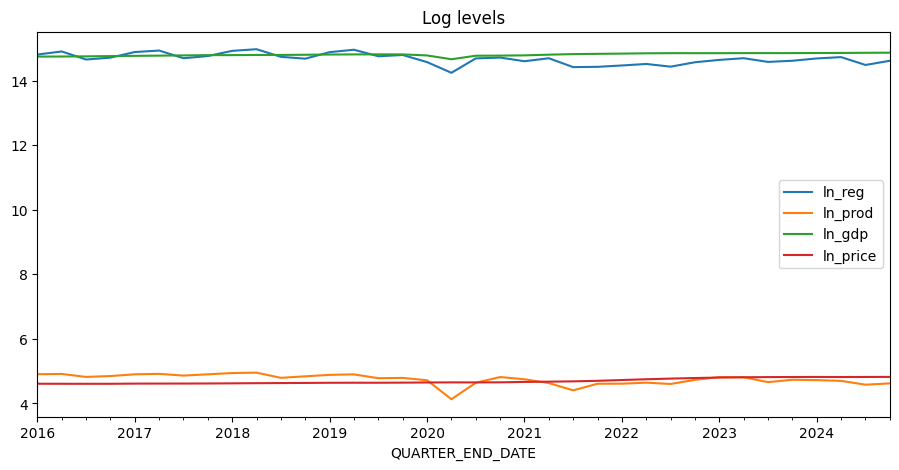

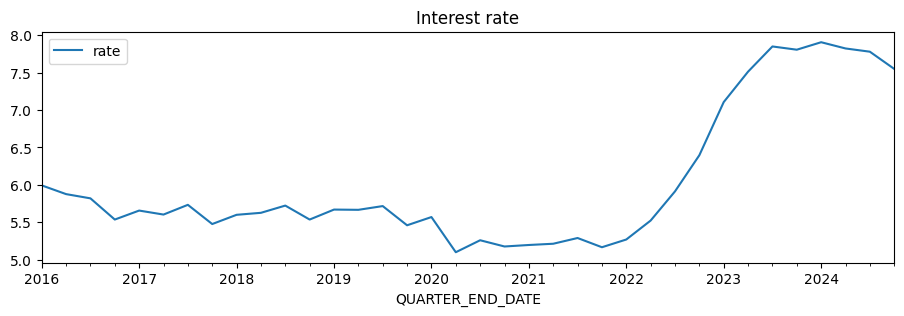

In [6]:
df[["ln_reg","ln_prod","ln_gdp","ln_price"]].plot(figsize=(11,5))
plt.title("Log levels")
plt.show()

df[["rate"]].plot(figsize=(11,3))
plt.title("Interest rate")
plt.show()

## Visual interpretation

The log-level series show clear trends and a major disruption around **2020**.  
Because trending macro series can cause misleading “spurious” regressions in levels, I test stationarity using ADF tests and then use an error-correction framework to separate:
- **long-run relationship (levels)** and  
- **short-run movements (differences)**.


In [7]:
# ADF test function

def adf_report(x, name, regression="ct"):
    x = x.dropna()
    stat, pval, usedlag, nobs, crit, icbest = adfuller(x, regression=regression, autolag="AIC")
    return {
        "series": name,
        "ADF_stat": stat,
        "p_value": pval,
        "lags": usedlag,
        "nobs": nobs,
        "reg": regression
    }

level_tests = []
for v in ["ln_reg","ln_prod","ln_gdp","ln_price","rate"]:
    level_tests.append(adf_report(df[v], v, regression="ct")) # allow trend in levels

pd.DataFrame(level_tests)

,series,ADF_stat,p_value,lags,nobs,reg
0,ln_reg,-3.991337,0.009046,0,35,ct
1,ln_prod,-3.930480,0.011011,0,35,ct
2,ln_gdp,-3.225307,0.079476,0,35,ct
3,ln_price,-1.250619,0.899606,5,30,ct
4,rate,-1.733411,0.735948,8,27,ct


## Stationarity tests in levels (ADF with constant + trend)

I used the Augmented Dickey–Fuller test with **constant + trend** (`regression="ct"`) for the level series because the plots suggest trending behavior.

**Results (levels, regression="ct"):**
- `ln_reg`: ADF = **-3.991**, p = **0.009**  
reject unit root (trend-stationary under this spec)
- `ln_prod`: ADF = **-3.930**, p = **0.011**  
reject unit root (trend-stationary under this spec)
- `ln_gdp`: ADF = **-3.225**, p = **0.079**  
borderline (do not reject at 5%)
- `ln_price`: ADF = **-1.251**, p = **0.900**  
non-stationary
- `rate`: ADF = **-1.733**, p = **0.736**  
non-stationary

**Interpretation:**  
Level stationarity results are mixed and sensitive to trend specification (common in small quarterly samples).  
Because the paper’s goal is to study **long-run equilibrium + short-run adjustment**, I will proceed with an **Engle–Granger + ECM** approach and cautiouslly interpret results.

In [8]:
# We test first differences

diff_tests = []
for v in ["ln_reg","ln_prod","ln_gdp","ln_price","rate"]:
    diff_tests.append(adf_report(df[v].diff(), "d_"+v, regression="c"))

pd.DataFrame(diff_tests)

,series,ADF_stat,p_value,lags,nobs,reg
0,d_ln_reg,-7.258397,1.706798e-10,1,33,c
1,d_ln_prod,-6.208682,5.576202e-08,1,33,c
2,d_ln_gdp,-7.494366,4.419503e-11,0,34,c
3,d_ln_price,-3.065517,2.921262e-02,4,30,c
4,d_rate,-3.683153,4.356461e-03,10,24,c


## Stationarity tests in first differences (ADF with constant)

I tested first differences with a constant only (`regression="c"`), which is standard.  

**Results (first differences):**  
- `d_ln_reg`: ADF = **-7.258**, p = **1.71e-10**  
stationary
- `d_ln_prod`: ADF = **-6.209**, p = **5.58e-08**  
stationary
- `d_ln_gdp`: ADF = **-7.494**, p = **4.42e-11**  
stationary
- `d_ln_price`: ADF = **-3.066**, p = **0.029**  
stationary at 5%
- `d_rate`: ADF = **-3.684**, p = **0.004**  
stationary

**Conclusion:**  
The differenced variables behave as stationary series, so short-run dynamics can be modelled in differences (ECM framework).


In [9]:
X_lr = df[["ln_prod","ln_gdp","ln_price","rate","post2019"]]
X_lr = sm.add_constant(X_lr)
y_lr = df["ln_reg"]

lr = sm.OLS(y_lr, X_lr).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                 ln_reg   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     25.84
Date:                Sun, 28 Dec 2025   Prob (F-statistic):           4.94e-10
Time:                        20:56:19   Log-Likelihood:                 43.241
No. Observations:                  36   AIC:                            -74.48
Df Residuals:                      30   BIC:                            -64.98
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.5412      7.844      1.471      0.1

## Long-run model (levels regression)

I estimate a long-run relationship where registrations depend on production activity, income, prices, interest rates, and a policy regime marker:

<center>$\ln(\text{REG}_t) = \alpha + \beta_1 \ln(\text{PROD}_t) + \beta_2 \ln(\text{GDP}_t) + \beta_3 \ln(\text{PRICE}_t) + \beta_4 \text{RATE}_t + \beta_5 \text{POST}_t + u_t$</center>

- Log form allows **elasticity-style** interpretation for GDP, production, and prices.
- I report **HAC (Newey–West)** standard errors because quarterly macro series often have autocorrelation.


In [10]:
# HAC (Newey–West) standard errors
lr_hac = lr.get_robustcov_results(cov_type="HAC", maxlags=4)
print(lr_hac.summary())

                            OLS Regression Results                            
Dep. Variable:                 ln_reg   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     55.12
Date:                Sun, 28 Dec 2025   Prob (F-statistic):           3.23e-14
Time:                        20:56:19   Log-Likelihood:                 43.241
No. Observations:                  36   AIC:                            -74.48
Df Residuals:                      30   BIC:                            -64.98
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.5412      4.213      2.739      0.0

## Long-run regression results (HAC, 4 lags)

Key coefficients (HAC standard errors):  

- `ln_prod`: **0.678** (p < **0.001**)  
  A 1% increase in production activity is associated with about a **0.68%** increase in registrations in the long run.
- `ln_gdp`: **0.315** (p = **0.482**)  
  Positive but not statistically precise in this sample.
- `ln_price`: **-1.088** (p = **0.204**)  
  Negative as expected, but not statistically significant in levels.
- `rate`: **0.062** (p = **0.126**)  
  Sign is not as expected; likely reflects proxy limitations and/or endogeneity.
- `post2019`: **-0.014** (p = **0.836**)  
  No clear level shift detected in this baseline long-run regression.

**Note:** the condition number is large (~**1.03e+04**), which suggests multicollinearity is possible. This can make some coefficients imprecise even if the overall fit is high.


In [11]:
# Engle–Granger cointegration test

resid = lr.resid

# Residual ADF: use constant only
stat, pval, usedlag, nobs, crit, icbest = adfuller(resid.dropna(), regression="c", autolag="AIC")
print("ADF on residuals (Engle–Granger step 2)")
print("ADF stat:", stat)
print("p-value:", pval)
print("lags:", usedlag, "nobs:", nobs)

ADF on residuals (Engle–Granger step 2)
ADF stat: -5.8904668270062945
p-value: 2.932680994252951e-07
lags: 1 nobs: 34


## Cointegration check (Engle–Granger step 2)

I test whether the **residuals** from the long-run regression are stationary:

- Residual ADF (constant): ADF = **-5.891**, p = **2.93e-07**

This strongly rejects a unit root in the residuals.  

**Conclusion:**  
Deviations from the estimated long-run relationship tend to shrink over time, which supports using an error-correction model (ECM).


In [12]:
df_ecm = df.copy()

df_ecm["ec_term"] = lr.resid.shift(1)

df_ecm["d_ln_reg"]   = df_ecm["ln_reg"].diff()
df_ecm["d_ln_prod"]  = df_ecm["ln_prod"].diff()
df_ecm["d_ln_gdp"]   = df_ecm["ln_gdp"].diff()
df_ecm["d_ln_price"] = df_ecm["ln_price"].diff()
df_ecm["d_rate"]     = df_ecm["rate"].diff()

df_ecm = df_ecm.dropna()
df_ecm.head(5)

,YEAR,QUARTER_NUM,QUARTER_YEAR,PASSENGER_CAR_REGISTRATIONS,MOTOR_VEHICLE_PROD_INDEX_2021,HICP_MOTOR_CARS,INTEREST_RATE_HOUSEHOLD_CONSUMPTION,GDP,POST_CO2_STANDARDS_2019,TRAVEL_BAN_COVID,...,ln_gdp,rate,post2019,covid,ec_term,d_ln_reg,d_ln_prod,d_ln_gdp,d_ln_price,d_rate
QUARTER_END_DATE,,,,,,,,,,,,,,,,,,,,,
2016-06-30,2016,2,2016Q2,2975769,135.966667,100.253333,5.876667,2545975.1,0,0,...,14.750024,5.876667,0,0,-0.052452,0.094962,0.008370,0.001920,-0.001429,-0.116667
2016-09-30,2016,3,2016Q3,2319907,124.000000,100.236667,5.820000,2558295.2,0,0,...,14.754852,5.820000,0,0,0.041892,-0.248975,-0.092128,0.004827,-0.000166,-0.056667
2016-12-31,2016,4,2016Q4,2457906,127.400000,100.256667,5.536667,2577850.2,0,0,...,14.762466,5.536667,0,0,-0.142842,0.057783,0.027050,0.007615,0.000200,-0.283333
2017-03-31,2017,1,2017Q1,2924412,134.433333,100.803333,5.656667,2598643.9,0,0,...,14.770500,5.656667,0,0,-0.088054,0.173784,0.053737,0.008034,0.005438,0.120000
2017-06-30,2017,2,2017Q2,3061756,136.300000,100.903333,5.603333,2615876.3,0,0,...,14.777110,5.603333,0,0,0.045279,0.045895,0.013790,0.006609,0.000992,-0.053333


## Error-correction model (ECM) (short-run dynamics)

The ECM explains quarterly changes in registrations:  

<center>$\Delta \ln(\text{REG}_t) = \gamma_0 + \gamma_1 \Delta \ln(\text{PROD}_t) + \gamma_2 \Delta \ln(\text{GDP}_t) + \gamma_3 \Delta \ln(\text{PRICE}_t) + \gamma_4 \Delta \text{RATE}_t + \lambda u_{t-1} + \delta \text{COVID}_t + \varepsilon_t$</center>  

- $u_{t-1}$ is the **lagged residual** from the long-run equation (the disequilibrium term).  
- If $\lambda < 0$ and significant, it indicates **adjustment back toward the long-run relationship**.

In [13]:
X = df_ecm[["d_ln_prod","d_ln_gdp","d_ln_price","d_rate","ec_term","covid"]]
X = sm.add_constant(X)
y = df_ecm["d_ln_reg"]

ecm = sm.OLS(y, X).fit()
print(ecm.summary())

                            OLS Regression Results                            
Dep. Variable:               d_ln_reg   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     22.14
Date:                Sun, 28 Dec 2025   Prob (F-statistic):           1.98e-09
Time:                        20:56:19   Log-Likelihood:                 44.360
No. Observations:                  35   AIC:                            -74.72
Df Residuals:                      28   BIC:                            -63.83
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0161      0.018      0.882      0.3

In [14]:
ecm_hac = ecm.get_robustcov_results(cov_type="HAC", maxlags=4)
print(ecm_hac.summary())

                            OLS Regression Results                            
Dep. Variable:               d_ln_reg   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     626.0
Date:                Sun, 28 Dec 2025   Prob (F-statistic):           1.75e-28
Time:                        20:56:19   Log-Likelihood:                 44.360
No. Observations:                  35   AIC:                            -74.72
Df Residuals:                      28   BIC:                            -63.83
Df Model:                           6                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0161      0.014      1.148      0.2

## ECM results (preferred specification: with 1 lag + HAC)

I focus on the ECM with 1 lag of differenced regressors (more realistic quarterly dynamics).

**Adjustment speed (main result):**
- `ec_term`: **-1.052** (p < **0.001**)  
Strong and negative adjustment. The magnitude suggests very fast correction within one quarter.

**Short-run drivers:**
- `d_ln_prod`: **0.703** (p < **0.001**)  
- `d_ln_prod_lag1`: **0.251** (p = **0.034**)  
Production growth has a strong positive short-run relationship with registration growth.

- `d_ln_price`: **-13.618** (p < **0.001**)  
- `d_ln_price_lag1`: **+11.904** (p < **0.001**)  
Large short-run price effect with partial reversal next quarter (this can happen with index timing and adjustment dynamics).

**Borrowing cost (rate):**
- `d_rate`: **-0.037** (p = **0.629**), `d_rate_lag1`: **-0.077** (p = **0.248**)  
Negative sign but not statistically significant in this specification.

**Pandemic dummy (as defined in the dataset):**
- `covid`: **+0.033** (p = **0.091**)  
This dummy spans 2020Q2–2022Q4, mixing collapse and recovery phases, so the sign should be interpreted as a **regime-period effect**, not a “shock” effect.


In [15]:
df_ecm2 = df_ecm.copy()

for v in ["d_ln_prod","d_ln_gdp","d_ln_price","d_rate"]:
    df_ecm2[v+"_lag1"] = df_ecm2[v].shift(1)

df_ecm2 = df_ecm2.dropna()

X2 = df_ecm2[[
    "d_ln_prod","d_ln_prod_lag1",
    "d_ln_gdp","d_ln_gdp_lag1",
    "d_ln_price","d_ln_price_lag1",
    "d_rate","d_rate_lag1",
    "ec_term","covid"
]]
X2 = sm.add_constant(X2)
y2 = df_ecm2["d_ln_reg"]

ecm2 = sm.OLS(y2, X2).fit()
ecm2_hac = ecm2.get_robustcov_results(cov_type="HAC", maxlags=4)

print(ecm2_hac.summary())

                            OLS Regression Results                            
Dep. Variable:               d_ln_reg   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     928.7
Date:                Sun, 28 Dec 2025   Prob (F-statistic):           1.63e-27
Time:                        20:56:20   Log-Likelihood:                 46.061
No. Observations:                  34   AIC:                            -70.12
Df Residuals:                      23   BIC:                            -53.33
Df Model:                          10                                         
Covariance Type:                  HAC                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0066      0.014     

# Note:
The ECM2 specification is treated as the main model, while the simpler ECM without lags will be used as a robustness check.

In [16]:
print("Durbin-Watson:", durbin_watson(ecm2.resid))

bg = acorr_breusch_godfrey(ecm2, nlags=4)
print("Breusch-Godfrey (stat, pval, fstat, fpval):", bg)

Durbin-Watson: 1.6551431021567098
Breusch-Godfrey (stat, pval, fstat, fpval): (np.float64(10.086011689181863), np.float64(0.03900348413511933), 2.0033695300394996, 0.13489549033423345)


In [17]:
white = het_white(ecm2.resid, ecm2.model.exog)
print("White test (LM stat, LM pval, F stat, F pval):", white)

White test (LM stat, LM pval, F stat, F pval): (np.float64(34.0), np.float64(0.4192380898312325), np.float64(nan), np.float64(nan))


## Diagnostics and why HAC is used

- Durbin–Watson = **1.655**  
Suggests positive autocorrelation.
- Breusch–Godfrey LM p-value = **0.039**  
Evidence of residual autocorrelation at 5%.
- White test p-value = **0.419**  
No strong evidence of heteroskedasticity.

Because autocorrelation is present, I rely on **HAC (Newey–West)** standard errors (4 lags) for inference.


In [18]:
df["post_x_prod"] = df["post2019"] * df["ln_prod"]

Xb = sm.add_constant(df[["ln_prod","ln_gdp","ln_price","rate","post2019","post_x_prod"]])
yb = df["ln_reg"]

break_model = sm.OLS(yb, Xb).fit()
break_hac = break_model.get_robustcov_results(cov_type="HAC", maxlags=4)

print(break_hac.summary())

# Joint test: did regime change matter (level or slope)?
print(break_model.f_test("post2019 = 0, post_x_prod = 0"))

                            OLS Regression Results                            
Dep. Variable:                 ln_reg   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     91.48
Date:                Sun, 28 Dec 2025   Prob (F-statistic):           1.67e-17
Time:                        20:56:20   Log-Likelihood:                 45.843
No. Observations:                  36   AIC:                            -77.69
Df Residuals:                      29   BIC:                            -66.60
Df Model:                           6                                         
Covariance Type:                  HAC                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.8456      6.366      0.447      

## Simple structural-change check (policy regime)

I allow the effect of production to differ after the policy period using an interaction term:

- `post2019`: **4.076** (p = **0.022**)  
- `post_x_prod`: **-0.844** (p = **0.020**)

However, the **joint test** that both are zero is:
- F = **2.277**, p = **0.121**

**Conclusion:** individual coefficients suggest differences after the policy period, but the joint test is not significant at 5%. With only 36 quarters and overlapping shocks, evidence of a structural break is **suggestive, not definitive**.


## Conclusions

Using quarterly EA20/EU aggregate data (2016Q1–2024Q4), I tested whether car registrations and production activity are linked by a stable long-run relationship and how the market adjusts in the short run.  

1) The Engle–Granger residual test strongly supports a stable long-run relationship (residual ADF = **-5.891**, p = **2.93e-07**).
2) The ECM shows a strong adjustment mechanism: `ec_term` is negative and highly significant (**-1.052**, p < 0.001), meaning deviations from the long-run relationship tend to correct quickly.
3) Production changes are a strong short-run driver of registration changes (`d_ln_prod` **0.703**, p < 0.001).
4) Price changes matter in the short run (large negative contemporaneous effect and partial reversal next quarter).
5) The interest-rate proxy does not produce stable, clearly interpretable effects in this sample, likely because it is an imperfect proxy for car-loan costs and may be endogenous.
6) The policy-period check is suggestive but not definitive (joint test p = **0.121**). Results should be interpreted cautiously due to the short sample and overlapping events (pandemic + supply constraints).

Overall, the evidence is consistent with a market that deviates during shocks but tends to adjust back toward a stable long-run relationship.

A limitation of the analysis is the short sample size, which reduces statistical power and may affect the precision of some coefficient estimates.
